In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import QueryByCommittee, RandomSampling, UncertaintySampling
from skactiveml.utils import MISSING_LABEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Load datasets


In [2]:
df = pd.read_csv("bmi.csv")

## Data Discovery


In [3]:
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Height,500.0,169.944,16.375261,140.0,156.0,170.5,184.0,199.0
Weight,500.0,106.000,32.382607,50.0,80.0,106.0,136.0,160.0
Index,500.0,3.748,1.355053,0.0,3.0,4.0,5.0,5.0


In [6]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Index'], dtype='object')

In [7]:
df.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [8]:
df.shape

(500, 4)

In [9]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Index'], dtype='object')

In [10]:
df.Index.unique()

array([4, 2, 3, 5, 1, 0], dtype=int64)

<Axes: xlabel='Index', ylabel='count'>

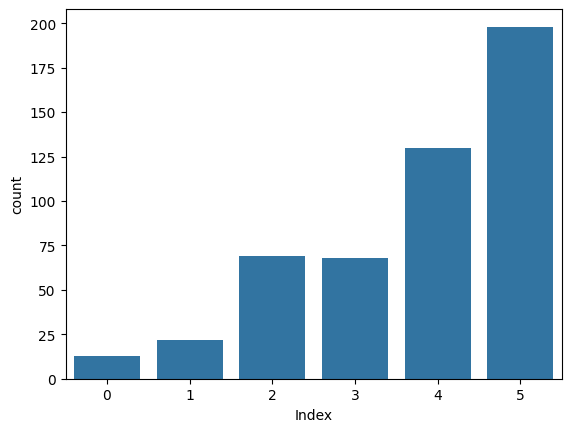

In [11]:
sns.countplot(x="Index", data=df)

In [12]:
df["Index"].value_counts()

Index
5    198
4    130
2     69
3     68
1     22
0     13
Name: count, dtype: int64

In [13]:
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

In [14]:
df

,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3
...,...,...,...,...
495,1,150,153,5
496,1,184,121,4
497,1,141,136,5
498,0,150,95,5


In [15]:
X = df.drop(["Index"], axis=1)
y = df["Index"]

In [16]:
X.head()

,Gender,Height,Weight
0,0,174,96
1,0,189,87
2,1,185,110
3,1,195,104
4,0,149,61


In [17]:
stdScaler = StandardScaler()
X[X.columns] = stdScaler.fit_transform(X)

In [18]:
X.head()

,Gender,Height,Weight
0,-1.020204,0.247939,-0.309117
1,-1.020204,1.164872,-0.587322
2,0.980196,0.920357,0.123647
3,0.980196,1.531645,-0.061823
4,-1.020204,-1.280283,-1.391027


## Apply SMOTE to oversample the minority class on the entire dataset


In [19]:
smote = SMOTE(random_state=42)

### Now X_resampled and y_resampled contain the oversampled data


In [20]:
X_resampled, y_resampled = smote.fit_resample(X, y)

Index
4    198
2    198
3    198
5    198
1    198
0    198
Name: count, dtype: int64


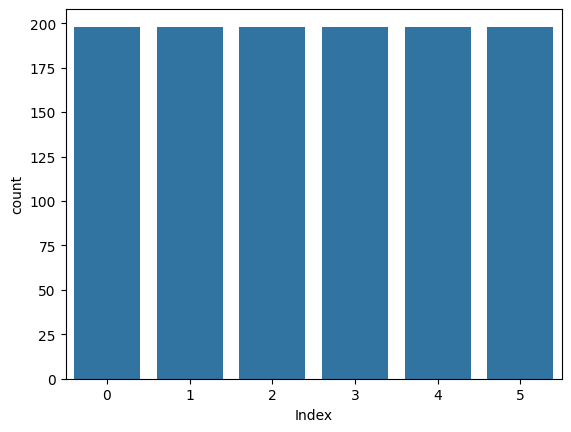

In [21]:
sns.countplot(x=y_resampled)
print(y_resampled.value_counts())

In [22]:
# !pip install -U scikit-activeml

# Active learning before balancing and after balancing


In [23]:
def evaluate_active_learning(datasets):
    for dataset_name, (X, y_true) in datasets.items():
        print(f"Evaluating dataset: {dataset_name}")
        clf = SklearnClassifier(RandomForestClassifier(), classes=np.unique(y_true))
        methods = [
            "margin_sampling",
            "entropy",
            "least_confident",
            "random_sampling",
            "KL_divergence",
        ]
        n_cycles = 100
        accuracies = {method: [] for method in methods}
        f1_scores = {method: [] for method in methods}

        for method in methods:
            if method in ["random_sampling"]:
                qs = RandomSampling(random_state=42)
            elif method in ["KL_divergence"]:
                qs = QueryByCommittee(random_state=42, method=method)
            else:
                qs = UncertaintySampling(method=method, random_state=42)

            y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
            clf.fit(X, y)
            for _ in range(n_cycles):
                if method in ["random_sampling"]:
                    query_idx = qs.query(X=X, y=y, batch_size=1)
                elif method in ["KL_divergence"]:
                    query_idx = qs.query(X=X, y=y, ensemble=clf, batch_size=1)
                else:
                    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)

                y[query_idx] = y_true[query_idx]
                clf.fit(X, y)

                accuracy = clf.score(X, y_true)
                f1 = f1_score(y_true, clf.predict(X), average="weighted")
                f1_scores[method].append(f1)
                accuracies[method].append(accuracy)

        # Print accuracies for each method
        print(f"Accuracies for dataset: {dataset_name}")
        for method, accuracy in accuracies.items():
            print(f"  Method: {method}, Accuracy: {accuracy[-1]:.4f}")
        for method, f1 in f1_scores.items():
            print(f"  Method: {method}, F1: {f1[-1]:.4f}")
            
        # Plot accuracies
        plt.figure(figsize=(10, 6))
        max_accuracy = 0
        best_method = ""
        for method, accuracy in accuracies.items():
            plt.plot(range(1, n_cycles + 1), accuracy, label=method, marker="o")
            if accuracy[-1] > max_accuracy:
                max_accuracy = accuracy[-1]
                best_method = method

        # Plot f1 scores
        for method, f1 in f1_scores.items():
            plt.plot(range(1, n_cycles + 1), f1, label=f"{method} (F1)", linestyle="--")

        plt.title(f"Accuracy vs Iterations - {dataset_name}")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the method with the highest accuracy
        print(
            f"The method with the highest accuracy for dataset {dataset_name} is {best_method} with an accuracy of {max_accuracy:.4f}.\n"
        )

In [24]:
datasets = {
    "unbalanced-data": (X, y),
    "imbalanced-data-after-balancing": (X_resampled, y_resampled),
}

Evaluating dataset: unbalanced-data


Accuracies for dataset: unbalanced-data
  Method: margin_sampling, Accuracy: 0.8100
  Method: entropy, Accuracy: 0.7920
  Method: least_confident, Accuracy: 0.7440
  Method: random_sampling, Accuracy: 0.7780
  Method: KL_divergence, Accuracy: 0.7800
  Method: margin_sampling, F1: 0.7979
  Method: entropy, F1: 0.7951
  Method: least_confident, F1: 0.7470
  Method: random_sampling, F1: 0.7728
  Method: KL_divergence, F1: 0.7839


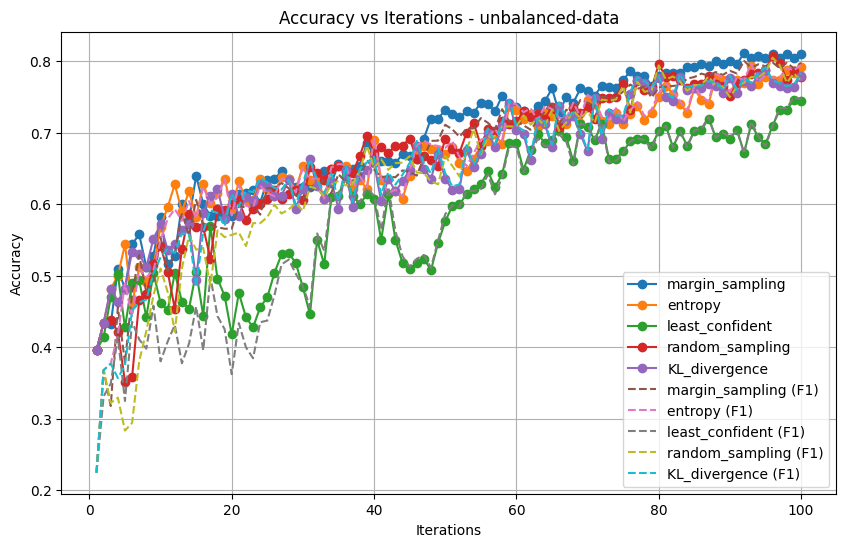

The method with the highest accuracy for dataset unbalanced-data is margin_sampling with an accuracy of 0.8100.

Evaluating dataset: imbalanced-data-after-balancing
Accuracies for dataset: imbalanced-data-after-balancing
  Method: margin_sampling, Accuracy: 0.8939
  Method: entropy, Accuracy: 0.8013
  Method: least_confident, Accuracy: 0.7736
  Method: random_sampling, Accuracy: 0.8232
  Method: KL_divergence, Accuracy: 0.7786
  Method: margin_sampling, F1: 0.8947
  Method: entropy, F1: 0.7972
  Method: least_confident, F1: 0.7668
  Method: random_sampling, F1: 0.8197
  Method: KL_divergence, F1: 0.7789


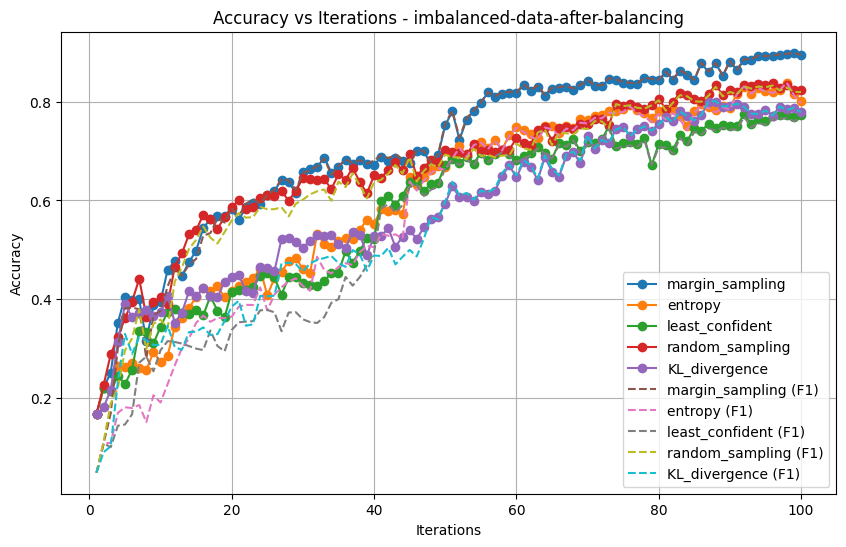

The method with the highest accuracy for dataset imbalanced-data-after-balancing is margin_sampling with an accuracy of 0.8939.



In [25]:
evaluate_active_learning(datasets)